Luc Cary

# Llama2-7b Wikilingia Experiments

These experiments benchmark the time required for [Llama2-7b](https://ai.meta.com/llama/) to generate summaries on [Wikilingua](https://github.com/esdurmus/Wikilingua) articles.

### Constraints

The below experiments were run for the task of generating text summaries for each article with the following constraints:

 - Number of GPUs: 1
 - 300 maximum generation tokens
 - No input truncation

### Optimizations

The experiments tested multiple optimization strategies on the LLM:

 - `4-bit`: [4-bit Quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
 - `8-bit`: [8-bit Quantization](https://huggingface.co/blog/hf-bitsandbytes-integration)
 - `flash-attn`: [Flash Attention](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2)
 - `none`: [Default model loader (no optimization)](https://huggingface.co/docs/transformers/main/model_doc/llama2) (no optimizations)
 - `vllm-awq`: [vLLM with AutoAWQ quantization](https://docs.vllm.ai/en/latest/quantization/auto_awq.html)

### Hardware

For the GPU requirement, these experiments were run on the following instance types:

 - A100 GPU Server (40GB GPU RAM)
 - T4 GPU Server (15GB GPU RAM)

All scripts were run on [Google Colab](https://colab.research.google.com/drive/1H9rehbj9naQ-req4P0xRxFch3PxIklSZ#scrollTo=PFHXYM-S1QqG).
Before each experiment, all Python dependencies were installed or updated and the runtime was restarted to clear memory.

### Dataset

 - 100 randomly sampled documents from Wikilingua's `english` corpus (same set for all experiments)
 - Average document length for the sample: 515.4 tokens

For the set of sampled article URLs in this experiment dataset, see `data/100_articles.txt`.


In [2]:
import seaborn as sns
import json
from collections import defaultdict
import pandas as pd

def read_json(path: str):
    with open(path) as f:
        return json.load(f)


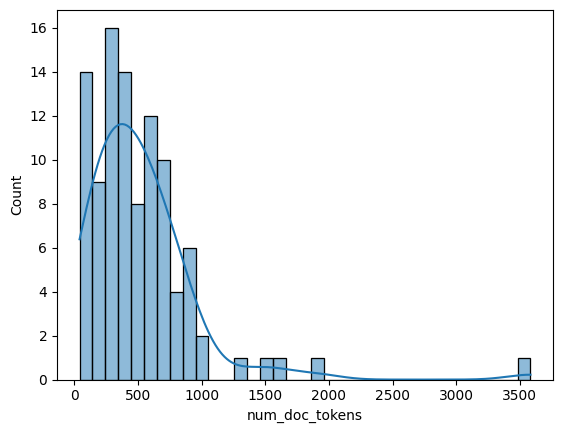

In [3]:
from pathlib import Path

data = defaultdict(list)

records = read_json('../data/data_22_t4_4-bit.json')
for record in records:
    data["num_doc_tokens"].append(record["num_doc_tokens"])

sns.histplot(data=data, x="num_doc_tokens", binwidth=100, kde=True)
print()


The above histogram shows the number of tokens per document and kernel density estimate of token count in the sample dataset of 100 documents, using the Llama2 tokenizer to encode text to tokens. Repeated sampling from the broader corpus shows that this sample is representative of the document lengths in the corpus, as shown in the below violin plot comparing counts of words between datasets:

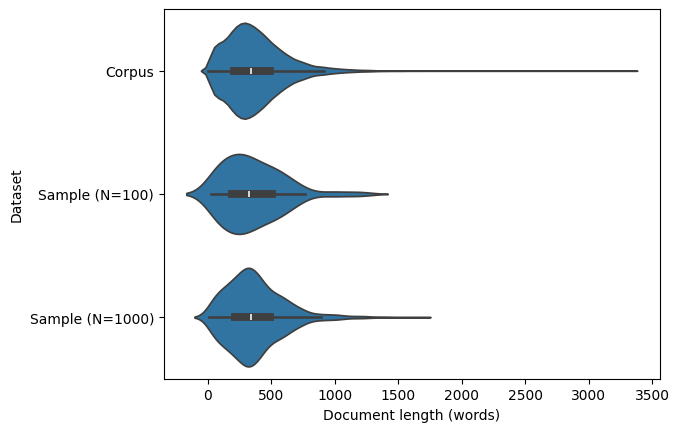

In [4]:
from datasets import load_dataset
from pathlib import Path

n100_dataset_file = Path("../data/100_articles.txt")
n100_dataset_urls = set(n100_dataset_file.read_text().split())

n1000_dataset_file = Path("../data/1000_articles.txt")
n1000_dataset_urls = set(n1000_dataset_file.read_text().split())


def get_document(data: dict) -> list:
    return data["article"]["document"]


def get_url(record: dict) -> list:
    return record["url"]


def is_in_n100_dataset(record: dict) -> bool:
    return get_url(record) in n100_dataset_urls


def is_in_n1000_dataset(record: dict) -> bool:
    return get_url(record) in n1000_dataset_urls


def has_document(record: dict) -> bool:
    return bool(get_document(record))


def count_words(record: dict) -> int:
    return len(get_document(record)[0].split(' '))


dataset = load_dataset("wiki_lingua", "english")
dataset = dataset["train"]
corpus_dataset = list(filter(has_document, dataset))
sample_n100_dataset = list(filter(is_in_n100_dataset, dataset))
sample_n1000_dataset = list(filter(is_in_n1000_dataset, dataset))

data = defaultdict(list)
for record in corpus_dataset:
    data["Document length (words)"].append(count_words(record))
    data["Dataset"].append("Corpus")

for record in sample_n100_dataset:
    data["Document length (words)"].append(count_words(record))
    data["Dataset"].append("Sample (N=100)")


for record in sample_n1000_dataset:
    data["Document length (words)"].append(count_words(record))
    data["Dataset"].append("Sample (N=1000)")

df = pd.DataFrame(data)
sns.violinplot(data=df, x="Document length (words)", y="Dataset")
print()

One primary distinguishing feature of the corpus is the existence of some longer documents (up to 3,000 words). Since these documents are rare, the sample datasets have slightly smaller documents.
However, the sample datasets used in this experiment had mean word counts that were similar to the overall Wikilingua corpus, which has a mean of 373 words.

In [5]:
df.groupby('Dataset', as_index=False)['Document length (words)'].mean()

,Dataset,Document length (words)
0,Corpus,373.412169
1,Sample (N=100),356.250000
2,Sample (N=1000),370.758000


Note that words can consist of multiple tokens, so their relationship is not 1-to-1. 

## Results

### Summary

The vLLM optimization had the fastest throughput, allowing the Llama2 7-billion parameter model to process 4.273 documents per second on the 100-document sample dataset.
This strategy when executed on the A100 was nearly an order of magnitude faster than any other strategy across all hardware types.
Using vLLM has less of an effect on the lower-memory T4 GPU, but still resulted
in a significant speedup over other T4 experiments, making the T4 competitive with the results of testing A100 inference without vLLM optimizations.

See the below chart for a visual comparison of inference speed, measured by the average number
of documents processed per second.

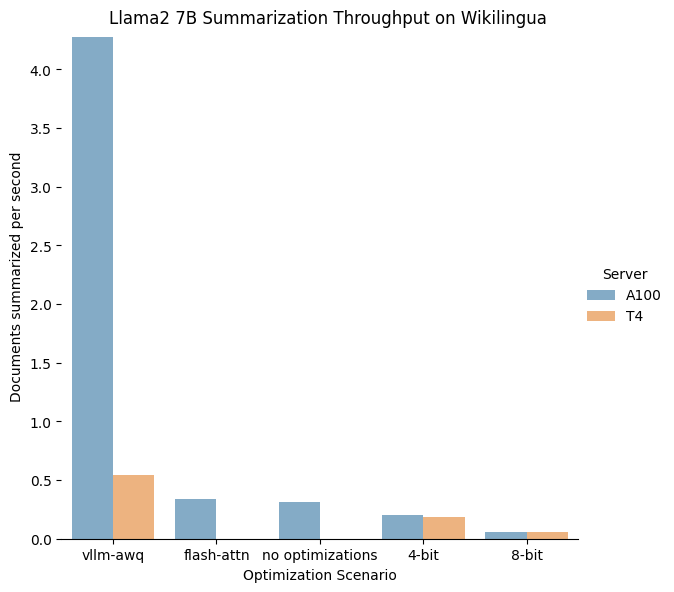

In [13]:
experiment_config = [
    {"experiment_number": 25, "server": "A100", "experiment_type": "vllm-awq", "results_file": "data/results_25_a100_vllm_awq.json", "data_file": "data/data_25_a100_vllm_awq.json",},
    {"experiment_number": 28, "server": "T4", "experiment_type": "vllm-awq", "data_file": "data/data_28_t4_vllm_awq.json", "results_file": "data/results_28_t4_vllm_awq.json"},
    {"experiment_number": 16, "server": "A100", "experiment_type": "flash-attn", "data_file": "data/data_16_a100_flash-attn.json", "results_file": "data/results_16_a100_flash-attn.json"},
    {"experiment_number": 17, "server": "A100", "experiment_type": "no optimizations", "data_file": "data/data_17_a100_default.json", "results_file": "data/results_17_a100_default.json"},
    {"experiment_number": 22, "server": "T4", "experiment_type": "4-bit", "data_file": "data/data_22_t4_4-bit.json", "results_file": "data/results_22_t4_4-bit.json"},
    {"experiment_number": 23, "server": "T4", "experiment_type": "8-bit", "data_file": "data/data_23_t4_8-bit.json", "results_file": "data/results_23_t4_8-bit.json"},
    {"experiment_number": 27, "server": "A100", "experiment_type": "4-bit", "data_file": "data/data_27_a100_4-bit.json", "results_file": "data/results_27_a100_4-bit.json"},
    {"experiment_number": 29, "server": "A100", "experiment_type": "8-bit", "data_file": "data/data_29_a100_8-bit.json", "results_file": "data/results_29_a100_8-bit.json"},
]

data = defaultdict(list)
for exp in experiment_config:
    results = read_json("../" + exp["results_file"])
    data["avg_doc_per_sec"].append(results["avg_doc_per_sec"])
    data["server"].append(exp["server"])
    data["experiment_type"].append(exp["experiment_type"])

g = sns.catplot(
    data=data, kind="bar",
    x="experiment_type", y="avg_doc_per_sec", hue="server",
    errorbar="sd", alpha=.6, height=6
)
g.fig.suptitle("Llama2 7B Summarization Throughput on Wikilingua")
g.despine(left=True)
g.set_axis_labels("Optimization Scenario", "Documents summarized per second")
g.legend.set_title("Server")

The same results can be found below in table format, ordered by the number of documents processed per second by the model:

| Experiment ID | Optimization | Docs/Second | Instance Type | ROGUE-1 F1 |
|---------------|--------------|-------------|---------------|------------|
| 25            | `vllm-awq`   | **4.273**   | `A100`        | 0.234      |
| 28            | `vllm-awq`   | **0.540**   | `T4`          | 0.254      |
| 16            | `flash-attn` | 0.339       | `A100`        | 0.282      |
| 17            | `none`       | 0.317       | `A100`        | 0.280      |
| 27            | `4-bit`      | 0.206       | `A100`        | 0.264      |
| 22            | `4-bit`      | 0.183       | `T4`          | 0.251      |
| 29            | `8-bit`      | 0.059       | `A100`        | 0.267      |
| 23            | `8-bit`      | 0.055       | `T4`          | 0.275      |


## Interpretation

The use of [PagedAttention](https://arxiv.org/abs/2309.06180), automatic batching of inputs, quantization of model weights, CUDA execution graph utilization and CUDA kernel optimizations, amongst other techniques, set vLLM aside as the obvious winner in this experiment, particularly for the A100 GPU.
Other scenarios like [Flash Attention](https://arxiv.org/abs/2205.14135) or removal of optimizations were not possible to run on the T4 GPU due to memory constraints and out of memory errors when processing the 100 document dataset without truncation of inputs or decreasing generated output lengths.

For 4-bit and 8-bit quantization of the LLM, the T4 and A100 inference speed was roughly equal. These quantization techniques allowed the T4 GPU to finish generation of summaries by reducing the memory footprint of the model. 

Another way to visualize this information is in the total time to generate summaries for 100 documents (including tokenization and loading):

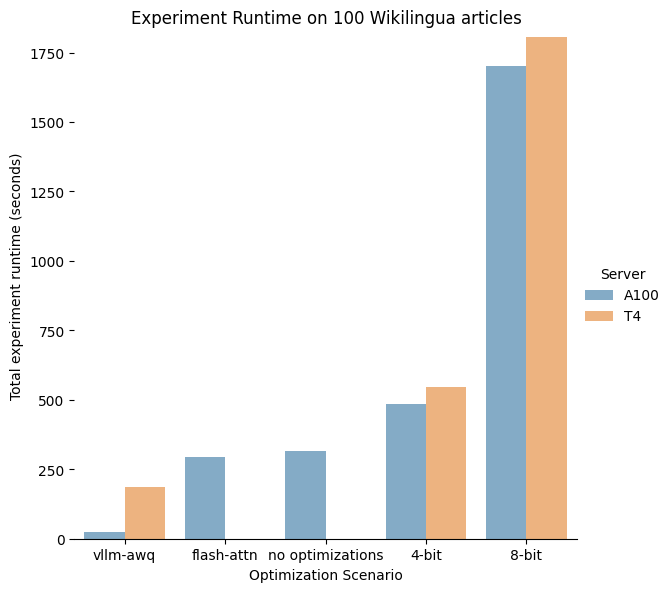

In [14]:
data = defaultdict(list)
for exp in experiment_config:
    results = read_json("../" + exp["results_file"])
    data["server"].append(exp["server"])
    data["experiment_type"].append(exp["experiment_type"])
    data["total_time"].append(results["total_time"])


g = sns.catplot(
    data=data, kind="bar",
    x="experiment_type", y="total_time", hue="server",
    errorbar="sd", alpha=.6, height=6
)
g.fig.suptitle("Experiment Runtime on 100 Wikilingua articles")
g.despine(left=True)
g.set_axis_labels("Optimization Scenario", "Total experiment runtime (seconds)")
g.legend.set_title("Server")

As seen above, the entire experiment runtime, accounting for tokenization, transfer of data to GPU, generation, and decoding, is significantly more time-intensive on the T4, particularly after quantization. 4-bit quantization dramatically speeds up the experiment compared to 8-bit on each GPU server, but 4-bit and 8-bit quantization techniques reduced latency compared to no optimizations whatsoever, and were mainly shown since it wasn't possible to run the T4 experiment without these techniques.

It should be noted that vLLM speedups appear to scale to larger datasets. For instance when testing the inference speed from vLLM on A100 with a larger dataset that randomly sampled 1000 documents, the throughput actually improved:

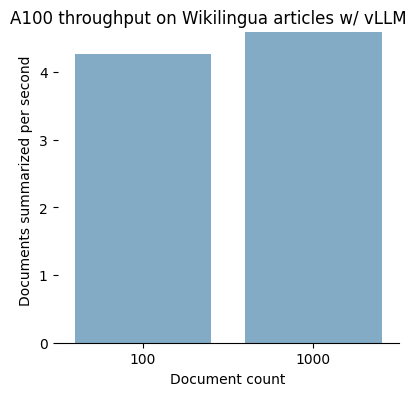

In [15]:
a100_vllm_experiment_results = [
    {"experiment_number": 25, "server": "A100", "experiment_type": "vllm-awq", "results_file": "data/results_25_a100_vllm_awq.json", "data_file": "data/data_25_a100_vllm_awq.json"},
    {"experiment_number": 30, "server": "A100", "experiment_type": "vllm-awq", "results_file": "data/results_30_a100_1k_vllm_awq.json", "data_file": "data/data_30_a100_1k_vllm_awq.json"},
]
data = defaultdict(list)
for exp in a100_vllm_experiment_results:
    records = read_json("../" + exp["data_file"])
    results = read_json("../" + exp["results_file"])
    data["document_count"].append(len(records))
    data["avg_doc_per_sec"].append(results["avg_doc_per_sec"])


g = sns.catplot(
    data=data, kind="bar",
    x="document_count", y="avg_doc_per_sec",
    errorbar="sd", alpha=.6, height=4
)
g.fig.suptitle("A100 throughput on Wikilingua articles w/ vLLM")
g.despine(left=True)
g.set_axis_labels("Document count", "Documents summarized per second")
print()

The throughput on the different sample dataset of 1000 documents was ~4.6 documents per second, the highest throughput of any experiment.

Since quantization and other optimizations discussed above can also impact quality, we look at the quality of the data these models produced next, as seen in the chart below:

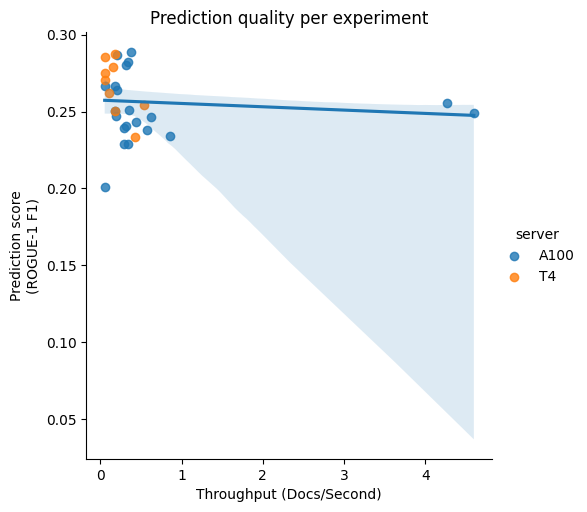

In [16]:
from pathlib import Path
import pandas as pd

data = defaultdict(list)
for results_file in Path("../data/").glob("results*.json"):
    if "_deepspeed" in results_file.name:
        # Skip garbage results from DeepSpeed experiments
        continue
    results = read_json(results_file)
    data["avg_doc_per_sec"].append(results["avg_doc_per_sec"])
    server = "A100" if "a100" in results_file.name.lower() else "T4"
    data["server"].append(server)
    data["pred_score"].append(results["pred_score"])

df = pd.DataFrame(data)
graph = sns.lmplot(x='avg_doc_per_sec', y='pred_score', hue='server', data=df, fit_reg=False)
ax = sns.regplot(x="avg_doc_per_sec", y="pred_score",
                data=df, scatter=False, ax=graph.axes[0, 0])
ax.set_xlabel("Throughput (Docs/Second)")
ax.set_ylabel("Prediction score\n(ROGUE-1 F1)")
ax.set_title('Prediction quality per experiment')
print()

Prediction quality was measured via by computing the [ROGUE-1](https://en.wikipedia.org/wiki/ROUGE_(metric))
F1 score for each example. The score is calculated by measuring the overlap of unigrams between the summaries
generated by the LLM with each corresponding ground truth summary from the Wikilingua dataset.

There appears to be a slight negative correlation between throughput and prediction quality, but the confidence
is very low as throughput increases, due to outliers: the A100 vLLM experiments. There is not enough data, nor
are there enough optimization strategies to say with confidence that optimizations necessarily entail a decrease
in prediction quality, but certain optimization strategies such as 4-bit and 8-bit quantization of model weights
are known to decrease prediction quality by reducing the precision of floating point operations.

Throughput is more influenced by sequence length, as is shown in the following charts:

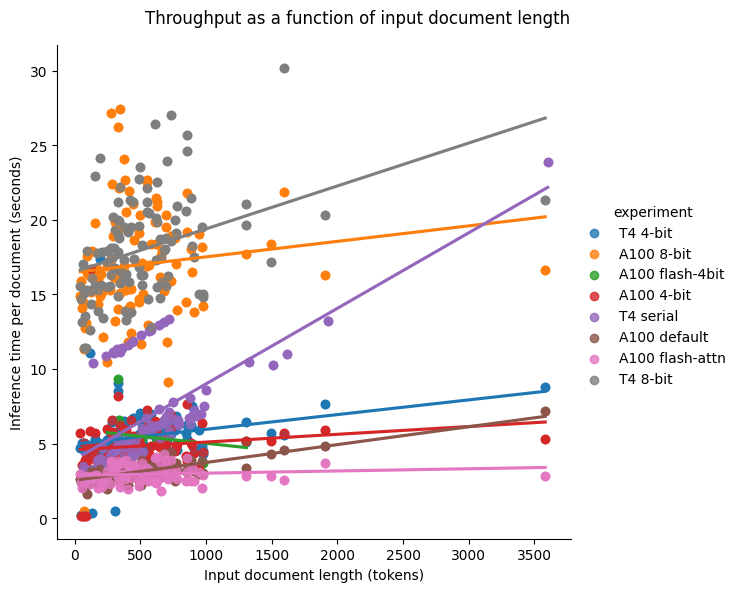

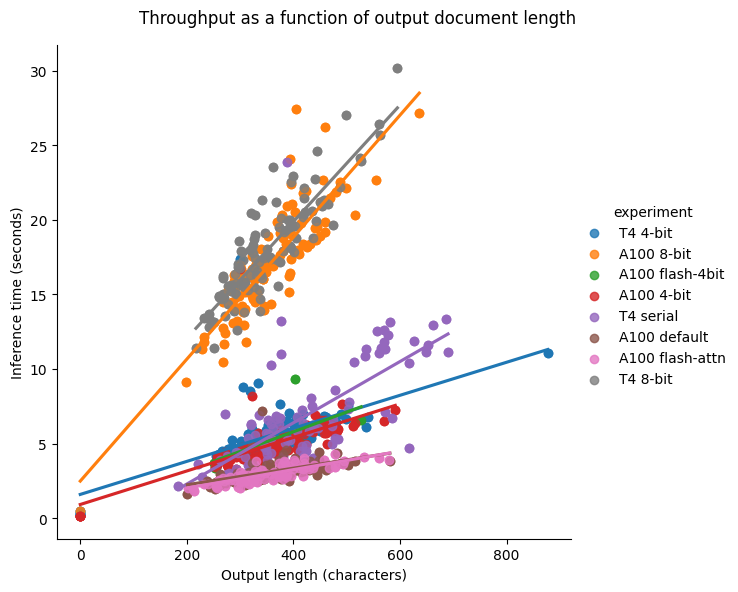

In [17]:
from pathlib import Path
import matplotlib.pyplot as plt

data = defaultdict(list)
for data_file in Path("../data/").glob("data*.json"):
    records = read_json(data_file)
    server = "A100" if "a100" in data_file.name.lower() else "T4"
    experiment = data_file.stem.split("_")[-1]
    if "inference_time" in records[0] and "num_doc_tokens" in records[0]:
        for record in records:
            data["experiment"].append(f"{server} {experiment}")
            data["inference_time"].append(record["inference_time"])
            data["num_doc_tokens"].append(record["num_doc_tokens"])
            data["generated_chars"].append(len(record["pred_summary"]))



df = pd.DataFrame(data)
g = sns.FacetGrid(df, hue='experiment', height=6)
g.fig.suptitle("Throughput as a function of input document length")
g.map(plt.scatter, "num_doc_tokens", "inference_time")
g.map(sns.regplot, "num_doc_tokens", "inference_time", ci=None)
g.set_axis_labels("Input document length (tokens)", "Inference time per document (seconds)")
g.add_legend()
print()

g = sns.FacetGrid(df, hue='experiment', height=6)
g.fig.suptitle("Throughput as a function of output document length")
g.map(plt.scatter, "generated_chars", "inference_time")
g.map(sns.regplot, "generated_chars", "inference_time", ci=None)
g.set_axis_labels("Output length (characters)", "Inference time (seconds)")
g.add_legend()
print()

Generally, there was a positive correlation between inference speed and input document length
as well as speed and generated text length, the degree of which depended on the optimization
strategy. This is intuitive, since the longer a given input document (i.e. a Wikilingua article) is,
the greater the context that the LLM needs to process, which increases computational load on the server.
For Transformer LLMs like Llama2, the attention mechanism has to compute and keep track of attention
weights over a larger set of tokens due to the increased length of the prompt document.

For LLM output generation, computational load is also increased by the length of the output due to
the attention mechanism as well, which requires keeping a larger set of weights in memory over the
larger text. Also, since LLMs generate outputs in a sequence, token by token, the larger the total
generated text is, the longer the model needs to spend generating it.

## Failed Experiments

Memory issues plagued the lower-memory T4 instance, which couldn't generate summaries on the Wikilingua
documents without optimizations.
Quantization (e.g. 4-bit and 8-bit) significantly helped to prevent out of memory errors on the
T4 instance type. Memory issues were less of a concern on the larger-memory A100 until experiments with batching.
There were many cases where the optimization techniques were insufficient to prevent an out of memory error on the GPU device, however. And, in addition to memory issues, there were many tests that failed due to hardware or software version incompatibility with
the optimization libraries or techniques.

Experiments that were unsuccessful due to high runtimes, skipped prompts, or memory issues on either the T4, the A100 or both include:

 - [DeepSpeed Optimizations](https://github.com/microsoft/DeepSpeed/tree/master/blogs/deepspeed-fastgen)
 - [DeepSpeed ZeRO-Inference](https://github.com/microsoft/DeepSpeedExamples/tree/master/inference/huggingface/zero_inference)
 - [IBM Foundation Model Stack](https://github.com/foundation-model-stack/foundation-model-stack)
 - [ONNX Inference](https://github.com/microsoft/Llama-2-Onnx)

The following table shows a variety of different errors from various experiments run on different document counts:

| Optimization             | GPU Type | Batch Size | Error                | Documents |
|--------------------------|----------|------------|----------------------|-----------|
| No optimizations         | `T4`     | 1          | `OutOfMemoryError`   | 10        |
| Flash Attention          | `T4`     | 1          | `RuntimeError`       | 10        |
| No optimizations         | `T4`     | 2          | `OutOfMemoryError`   | 10        |
| vLLM (no quantization)   | `T4`     | dynamic    | >90% prompts skipped | 100       |
| DeepSpeed                | `T4`     | dynamic    | `OutOfMemoryError`   | 100       |
| No optimizations         | `A100`   | 4          | `OutOfMemoryError`   | 10        |
| Flash Attention          | `A100`   | 10         | `OutOfMemoryError`   | 100       |
| DeepSpeed                | `A100`   | dynamic    | Garbage outputs      | 100       |

The Flash Attention experiments were only run on the A100 GPU since it's incompatible with the T4 machine's older GPU type,
since Flash Attention requires Ampere GPUs or newer. Batching, meanwhile resulted in memory errors for all batch sizes (greater than 1) on the T4, and additionally occurred for all batches after 10 documents had been processed on the A100. This suggests that additional memory optimizations - likely of the sort included out-of-the-box in the vLLM library - are required to clear the memory. The above batching experiments used a naive approach of concatenating tensors of prompts based on a fixed batch size, whereas vLLM generates the batch sizes dynamically based on available memory and the total sequence lengths.

DeepSpeed experiments failed with out of memory errors or CUDA compute capabilities version incompatibility issues on the T4 machines in all cases. The DeepSpeed tests showed promising throughput metrics on the A100, but were generating garbage outputs due to a deadlock error which caused the KV cache to reset mid-experiment upon each execution.

I also tested some of the experiments on a V100 code, and noted that Flash Attention and vLLM with AutoAWQ quantization were incompatible
with the GPU type or capability version.

## Conclusion

Using vLLM to optimize LLM inference results in dramatic improvements in latency and allow
large models to run on smaller hardware at high speeds. For lower-memory GPU instances, such as the T4,
quantization is critical to avoiding out of memory errors. In general, there are many
compatibility issues in optimization libraries due to different hardware setups and library versions.

It should be noted that runtime and quality fluctuate slightly between each run due to
differences in the server environment and non-determinism in the model generation step, respectively.
An area of improvement for these experiments is to improve the consistency of the results through repeated executions,
running the experiments on larger datasets, and running repeated sampling to calculate more robust benchmarks.

## Appendix

### Code

All scripts used to run these experiments can be found in the following GitHub repository:

https://github.com/lcary/ai-summarization-benchmarks/



### Cost

Note that using the A100 requires a Colab Pro subscription, and eats up about 2 credits per hour.
Additionally, after a certain amount of time using the free T4, Colab pre-empted experiment
sessions in faver of paying customers. The most expensive part of this experiment was
collecting baseline benchmarks on non-optimized models, since they take the longest to run.

All in all, this experiment costed `$20.00` to run (200 credits at `$10.00` per 100 credits).

## Other Issues

### Flash Attention Compatibility

Note that Flash Attention experiments were only run on the A100 GPU since it's incompatible with the T4 machine,
due to the T4 having an unsupported, older GPU type
(error: `RuntimeError: FlashAttention only supports Ampere GPUs or newer.`).
Also, note that the `4-bit` quantization experiments use 16-bit floating points for the computational type
via `bnb_4bit_compute_dtype`, while for `8-bit` quantization, the computational type is set to the default.

Note that Flash Attention is also incompatible on V100 GPU servers.

### vLLM Memory and Compatibility Issues

The `vllm` experiments run without AutoAWQ quantization consumes the entirety of the T4 machine's
GPU memory when optimizing KV cache and during CUDA graph creation, resulting in out of memory issues unless we decrease the maximum model
sequence length (prompt and output combined) is decreased, which results in the majority of documents being skipped.
This is fixed by AWQ quantization at the expense of throughput. More info on this issue can
be found in the `scripts/run_llama_7b_vllm.py` script docstring.

Note vLLM with AWQ is incompatible on V100 GPU servers.
